In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import squidpy as sq
import sys
sys.path.append('..')
import cellrefiner
import seaborn as sns
from matplotlib import pyplot as plt
import scanpy as sc

/home/kxy/miniconda3/envs/cellrefiner1/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
db = pd.read_csv(R'LR.csv')

In [19]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])].copy()
adata_sc = sq.datasets.sc_mouse_cortex()

# run cellrefiner

In [6]:
cr = cellrefiner.CellRefiner(adata_st=adata_st,adata_sc=adata_sc,db=db)
cr.gen_w()

In [7]:
cr.pp_cr(group = "cell_subclass")
cr.sim_cr(iterations=10,W=cr.W,tissue_bound=1)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.613, KL reg: 0.001
Score: 0.733, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000


INFO:root:Saving results..


# assemble anndata

In [21]:
adata_cr = adata_sc[cr.cell5m,:]
adata_cr.obsm['spatial'] = cr.pos[-1,:,:]
adata_cr.obs['cell_to_spot'] = np.tile(np.arange(adata_st.shape[0]).reshape(-1,1),(1,cr.k)).flatten()
print(adata_cr)

AnnData object with n_obs × n_vars = 1620 × 36826
    obs: 'sample_name', 'organism', 'donor_sex', 'cell_class', 'cell_subclass', 'cell_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_to_spot'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


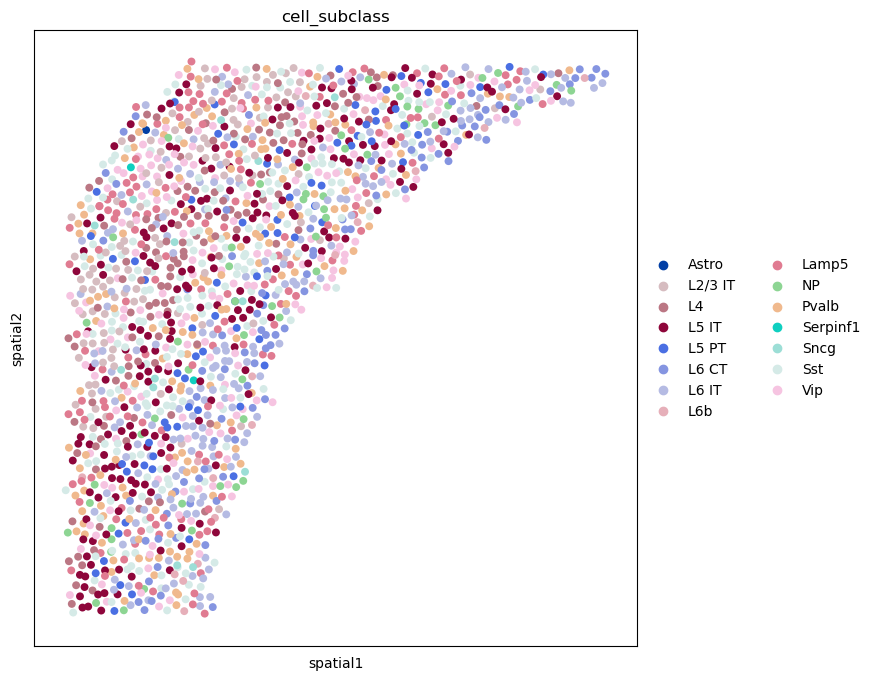

In [22]:
fig,ax = plt.subplots(figsize=(8,8))
sc.pl.spatial(adata_cr,spot_size=100,color="cell_subclass",ax=ax)
ax.set_axis_off()

# SEM simulation

In [23]:
re = 2
param = {"rm_intra":re,
         "rm_inter":re*1.2,
         "dt":0.04,
         'sigma':1,
         'alpha':(8,0.5),
         'gamma':0.001}
sem = cellrefiner.SEM(20,re,
                      adata=adata_cr,
                      cluster_key="cell_subclass",
                      sim_name='mouse_cortex')

to disable logging:
    
    import logging
    cuda_logger = logging.getLogger('numba.cuda.cudadrv.driver')
    cuda_logger.setLevel(logging.ERROR)  # only show error
    

In [24]:
sem.sim_gpu(param,T=2000)
# sem.save_sim()

INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 10497600 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 259200 bytes
INFO:numba.cuda.cudadrv.driver:d

Computing alpha-shape with parameters: alpha=None, ns=10, r=1.2


<AxesSubplot:>

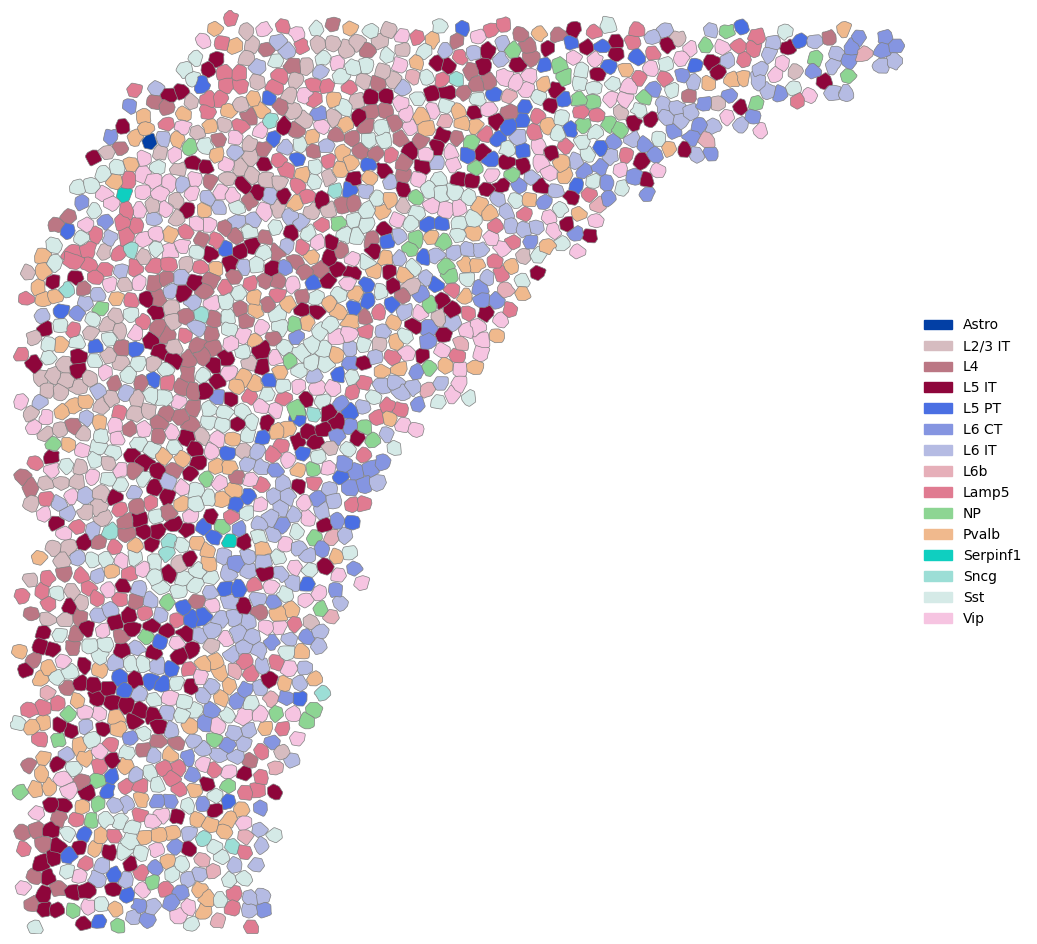

In [12]:
fig,ax=plt.subplots(figsize=(12,12))
cellrefiner.pl.alphashape_plot(sem,ax=ax,boundary_color='gray',boundary_width=0.5,enable_legend=True,show_axis=False)

# contact signal

In [25]:
# load ligand-receptor DB
sc.pp.filter_genes(adata_cr,min_cells=10)
df_cellchat = cellrefiner.pp.ligand_receptor_database(species='mouse', signaling_type='Cell-Cell Contact', database='CellChat')
df_cellchat_filtered = cellrefiner.pp.filter_lr_database(df_cellchat, adata_cr, min_cell_pct=0.01)
display(df_cellchat_filtered)

,Ligand,Receptor,Pathway,Type
0,Alcam,Cd6,ALCAM,Cell-Cell Contact
1,App,Cd74,APP,Cell-Cell Contact
2,Cadm1,Cadm1,CADM,Cell-Cell Contact
3,Cadm3,Cadm3,CADM,Cell-Cell Contact
4,Cd200,Cd200r1,CD200,Cell-Cell Contact
...,...,...,...,...
137,Sema6a,Plxna4,SEMA6,Cell-Cell Contact
138,Sema6b,Plxna4,SEMA6,Cell-Cell Contact
139,Sema7a,Itgb1_Itga1,SEMA7,Cell-Cell Contact
140,Sema7a,Plxnc1,SEMA7,Cell-Cell Contact


In [ ]:
sem.compute_contact()
cellrefiner.tl.contact_signal(df_cellchat_filtered,sem=sem) # add signal to .obsp, add 'contact_signal_info' to .uns
cellrefiner.tl.signal_vector(adata_cr)
print(adata_cr)

add .obsp['contacts'], .uns['contacts']
AnnData object with n_obs × n_vars = 1620 × 26818
    obs: 'sample_name', 'organism', 'donor_sex', 'cell_class', 'cell_subclass', 'cell_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_to_spot'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap', 'contacts', 'contact_signal'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'contacts', 'Alcam-Cd6', 'App-Cd74', 'Cadm1-Cadm1', 'Cadm3-Cadm3', 'Cd200-C

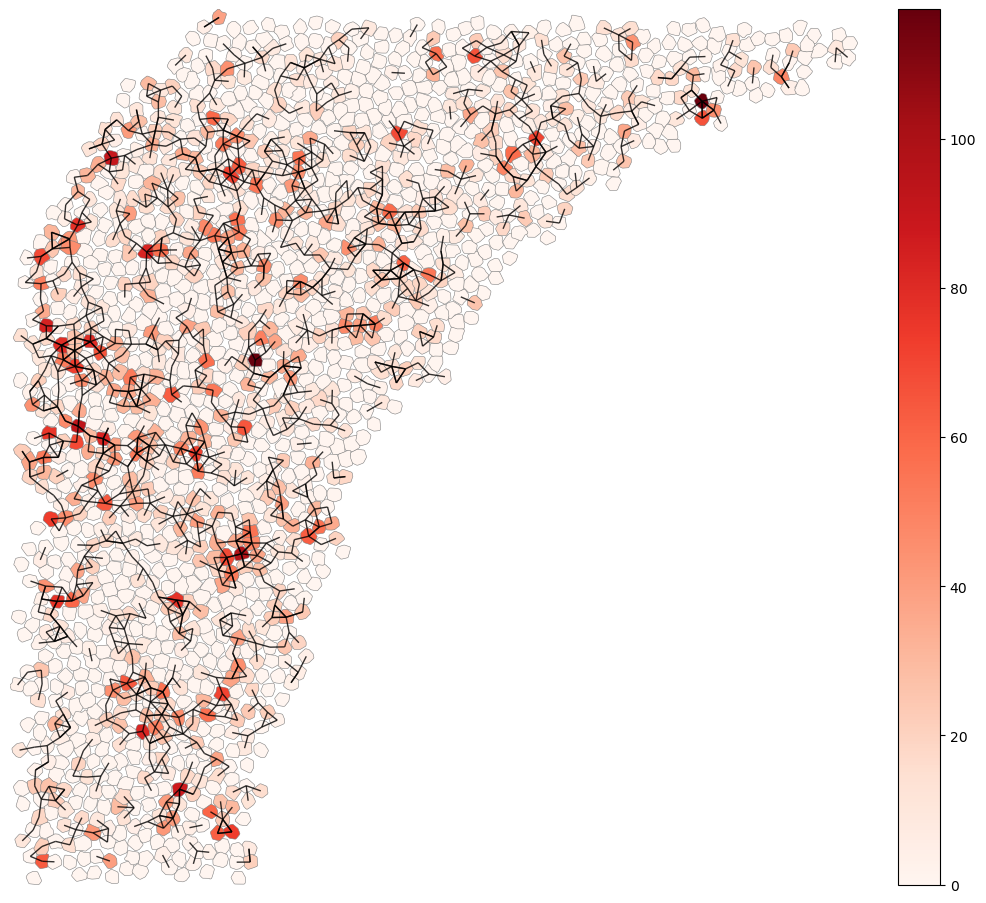

In [30]:
fig,ax=plt.subplots(figsize=(12,12))
sig_name = 'NOTCH'
cellrefiner.pl.alphashape_plot(sem,vis_key=sig_name,summary='sender',boundary_color='gray',cmap_name='Reds',boundary_width=0.4,ax=ax,enable_colorbar=True)
cellrefiner.pl.vis_contact_signal(sem,signal=sig_name,line_color = 'k', line_width=1, ax=ax, line_alpha=0.8)
ax.set_axis_off()

<AxesSubplot:>

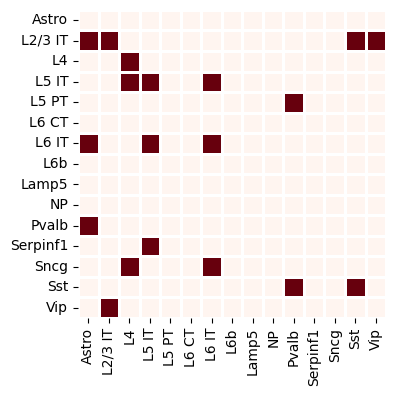

In [36]:
cellrefiner.tl.cluster_communication(adata_cr,cluster_key='cell_subclass',signal=sig_name)
fig,ax=plt.subplots(figsize=(6,4))
sns.heatmap(adata_cr.uns[f'cell_subclass-{sig_name}']['communication_pvalue']<0.05,square=True,linewidths=1,ax=ax,cmap='Reds',cbar=False)